# Практика №3

Теперь в качестве акустической модели мы будем использовать простой DNN классификатор. На каждом кадре записи мы будем подавать его вектор признаков на DNN, которая будет выдавать "распределение вероятностей" по фонемам. Далее это распределение мы будем использовать в нашем алгоритме распознавания по словарю. Схема работы такого классификатора представлена ниже: 

![](https://drive.google.com/uc?export=view&id=1dv0VuE8DIoKXETbvnZq2PMixkWMCJOxr)

### Bootstrap

In [11]:
!gdown --id '1meikF0XqBUnVZKoY3160MQ0R25lq-EMu'
!gdown --id '1f0LkW6I3Q5CnOThuNFAJ9umgnb2eU4Ox'

!unzip -q lab2.zip
!unzip -q train_librispeech_10h.zip
!mv lab2 lab3
!mv train_librispeech_10h lab3/data
!rm -rf lab2.zip sample_data train_librispeech_10h.zip
%cd lab3

Downloading...
From: https://drive.google.com/uc?id=1meikF0XqBUnVZKoY3160MQ0R25lq-EMu
To: /content/lab2.zip
100% 1.66M/1.66M [00:00<00:00, 26.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1f0LkW6I3Q5CnOThuNFAJ9umgnb2eU4Ox
To: /content/train_librispeech_10h.zip
679MB [00:10, 63.4MB/s]
/content/lab3


In [12]:
import os
import numpy as np
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa, librosa.display
import torch
import torch.nn as nn
import torch.functional as F


%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 5.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [22]:
conv1 = nn.Conv1d(
            in_channels=1,
            out_channels=3,
            kernel_size=3,
            stride=1,
            padding=0,
            dilation=2,
        )
output1 = torch.rand((20, 1, 9))
conv1(output1).size()

torch.Size([20, 3, 5])

In [56]:
modules = nn.ModuleList([
            nn.Conv1d(1, 3, 3),
            nn.BatchNorm1d(3),
            nn.PReLU(3),

            nn.Conv1d(3, 6, 3),
            nn.BatchNorm1d(6),
            nn.PReLU(6),

            nn.Conv1d(6, 9, 3),
            nn.BatchNorm1d(9),
            nn.PReLU(9),

            nn.Flatten(),

            nn.Linear(7*9, 86),
        ])

b=torch.rand((20, 1, 13))
for i in modules:
    b = i(b)
b.size()

torch.Size([20, 86])

In [59]:
print(modules)

ModuleList(
  (0): Conv1d(1, 3, kernel_size=(3,), stride=(1,))
  (1): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): PReLU(num_parameters=3)
  (3): Conv1d(3, 6, kernel_size=(3,), stride=(1,))
  (4): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): PReLU(num_parameters=6)
  (6): Conv1d(6, 9, kernel_size=(3,), stride=(1,))
  (7): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): PReLU(num_parameters=9)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=63, out_features=86, bias=True)
)


In [13]:
# загрузка списка допустимых фонем:
def load_phones_dict(phones_file):
    phones_dict = {}
    with open(phones_file, encoding='utf-8') as fn:
        for index, line in enumerate(fn):
            phones_dict[line.strip()] = index
    return phones_dict

# загрузка покадровой фонемной разметки в словарь:
def load_phone_aligment(aligment_file):
    ali_dict = {}
    with open(aligment_file, encoding='utf-8') as fn:
        for line in fn:
            line = line.strip().split()
            ali_dict[line[0]] = line[1:]
    return ali_dict

# подсчет акустиеских признаков для записей из папки:
def load_data_dict(dir_path, count=None):
    data_dict = {}
    step = 0
    for wav_name in tqdm(os.listdir(dir_path)):
        x, sr = librosa.load(os.path.join(dir_path, wav_name), sr=None) 
        mfcc = librosa.feature.mfcc(x, sr=sr, n_mfcc=13, 
                                    n_fft=int(sr * 0.025),
                                    hop_length=int(sr * 0.01))
        step += 1
        if count and step == count:
            print(f'Early stop at {step}th file..')
            break
        data_dict[wav_name.split('.')[0]] = mfcc.T
    return data_dict


phones_file = 'data/train_librispeech_10h/phones'
phones_dict = load_phones_dict(phones_file)

ali_file = 'data/train_librispeech_10h/ali_phones.txt'
ali_dict = load_phone_aligment(ali_file)

train_records_dir = 'data/train_librispeech_10h/wav_dir'
feats_dict = load_data_dict(train_records_dir, count=2000)

Early stop at 2000th file..


### Априорная вероятность:

![](https://drive.google.com/uc?export=view&id=1WhjclhXm2POYsCgvxp3iAIOvT9F_k8If)

In [64]:
# объединение кадров признаков с соответствующими им фонемам:
def combain_data(ali_dict, feats_dict, phones_dict, side_context=0):
    X_list, y_list = [], []
    priors_list = [0] * len(phones_dict)
    for file_name in feats_dict.keys():
        file_feats = feats_dict[file_name]
        file_ali = ali_dict[file_name]
        for frame in range(side_context, min(len(file_feats), len(file_ali)) - side_context):
            data = [
                file_feats[i]
                for i in range(frame-side_context, frame+side_context+1)
            ]

            X_list.append(np.concatenate(data))
            y_list.append(phones_dict[file_ali[frame]])
            priors_list[phones_dict[file_ali[frame]]] += 1

    return X_list, y_list, np.array(priors_list)/sum(priors_list)

side_context = 0
X_list, y_list, priors_list = combain_data(ali_dict, feats_dict, phones_dict, side_context)

In [65]:
from sklearn.model_selection import train_test_split

class CommonDataSet():

    def __init__(self, X_data, y_data, device, valid_proportion=0.1):
        self.train, self.valid, self.y_train, self.y_test = train_test_split(
            X_data, y_data, test_size=valid_proportion, random_state=42,
        )
        self.device = device
        
    def num_batches(self, batch_size):
        return len(self.train) // batch_size        
        
    def next_batch(self, batch_size):
        for i in range(self.num_batches(batch_size)):
            batch_xs = torch.tensor(
                self.train[i * batch_size:(i + 1) * batch_size],
                dtype=torch.float32,
                device=self.device,
            )

            batch_ys = torch.tensor(
                self.y_train[i * batch_size:(i + 1) * batch_size],
                dtype=torch.int64,
                device=self.device,
            )

            yield batch_xs, batch_ys

In [66]:
class MyNet(nn.Module):

    def __init__(self, input_dim, output_dim):
        super(MyNet, self).__init__()
        # params:
        input_dim = input_dim       # размерность входных признаков
        n_nodes_hl1 = 256
        n_nodes_hl2 = 256
        n_nodes_hl3 = 256
        n_nodes_hl4 = 256
        output_dim = output_dim     # количество выходных классов (фонем)
        # FC layers:
        self.fc1 = nn.Linear(input_dim, n_nodes_hl1)
        self.fc2 = nn.Linear(n_nodes_hl1, n_nodes_hl2)
        self.fc3 = nn.Linear(n_nodes_hl2, n_nodes_hl3)
        self.fc4 = nn.Linear(n_nodes_hl3, n_nodes_hl4)
        self.fc5 = nn.Linear(n_nodes_hl4, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return (x)

class MyNet2(nn.Module):

    def __init__(self, input_dim, output_dim):
        super(MyNet2, self).__init__()

        self.module_list = nn.ModuleList([
            nn.Conv1d(1, 3, 3),
            nn.BatchNorm1d(3),
            nn.PReLU(3),

            nn.Conv1d(3, 6, 3),
            nn.BatchNorm1d(6),
            nn.PReLU(6),

            nn.Conv1d(6, 9, 3),
            nn.BatchNorm1d(9),
            nn.PReLU(9),

            nn.Flatten(),

            nn.Linear(7*9, output_dim),
        ])

    def forward(self, x):
        x = x.unsqueeze(1)
        for m in self.module_list:
            x = m(x)

        return x

In [67]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load data:
data_set = CommonDataSet(X_list, y_list, device)

batch_size = 256

# training network model:
start = time.time() 
net = MyNet2(input_dim=(X_list[0].shape[0]),
            output_dim=len(phones_dict.keys())).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 4, gamma=0.5)

loss_list = []

print('TRAINIG IS STARTED...')
for epoch in range(30):
    running_loss = 0
    counter = 0
    for batch_xs, batch_ys in tqdm(data_set.next_batch(batch_size), \
                                   total=data_set.num_batches(batch_size), \
                                   desc='epoch {}'.format(epoch)):
        optimizer.zero_grad()
        output = net(batch_xs)

        loss = criterion(output, batch_ys)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        counter += 1
        
    print('loss is: {:.4f}'.format((running_loss / counter)))
    loss_list.append(running_loss / counter)

    lr_scheduler.step()
    
end = time.time()
minutes = (end - start) // 60
seconds = np.mod((end - start), 60)
print('Time is: {} min {} sec'.format(int(minutes), int(seconds)))

<bound method Module.modules of MyNet2(
  (module_list): ModuleList(
    (0): Conv1d(1, 3, kernel_size=(3,), stride=(1,))
    (1): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=3)
    (3): Conv1d(3, 6, kernel_size=(3,), stride=(1,))
    (4): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=6)
    (6): Conv1d(6, 9, kernel_size=(3,), stride=(1,))
    (7): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): PReLU(num_parameters=9)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=63, out_features=86, bias=True)
  )
)>
TRAINIG IS STARTED...



loss is: 2.2248



loss is: 2.1908



loss is: 2.1851



loss is: 2.1823



loss is: 2.1709



loss is: 2.1699



loss is: 2.1693



loss is: 2.1688



loss is: 2.1630



loss is: 2.1626



loss is: 2.1623



loss is: 2.1620



loss is: 2.1591



loss is: 2.1588



loss is: 2.1587



loss is: 2.1586



loss is: 2.1570



loss is: 2.1569



loss is: 2.1568



loss is: 2.1567



loss is: 2.1559



loss is: 2.1558



loss is: 2.1558



loss is: 2.1558



loss is: 2.1553



loss is: 2.1553



loss is: 2.1553



loss is: 2.1553



loss is: 2.1551



loss is: 2.1550
Time is: 17 min 55 sec


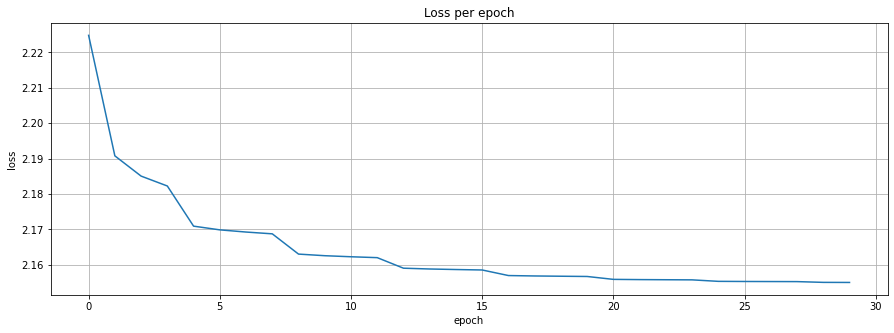

In [68]:
plt.rcParams['figure.figsize'] = (15.0, 5.0)
plt.plot(loss_list)
plt.title('Loss per epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.show()

In [72]:
net.cpu()
with torch.no_grad():
    correct_cnt = 0
    for ftr, true_label in tqdm(zip(data_set.valid, data_set.y_test), total=len(data_set.valid)):
        ftr = torch.from_numpy(ftr).float().unsqueeze(0)
        output = net.forward(ftr)
        correct_cnt += (output.argmax().item() == true_label)
        
    print("Total frame accuracy is {:.3f}".format(correct_cnt / len(data_set.valid)))


Total frame accuracy is 0.173


In [74]:
class_correct = [0 for x in range(len(phones_dict.keys()))]
class_total = [0 for x in range(len(phones_dict.keys()))]
net.cpu()
with torch.no_grad():
    for ftr, true_label in tqdm(zip(data_set.valid, data_set.y_test), total=len(data_set.valid)):
        ftr = torch.from_numpy(ftr).float().unsqueeze(0)
        output = net.forward(ftr)
        predict_label = output.argmax().item()
        
        class_correct[predict_label] += (predict_label == int(true_label))
        class_total[int(true_label)] += 1

for idx, phone in enumerate(phones_dict.keys()):
    if class_total[idx]:
        print('{:3s}: {:.2f} : {}/{}'.format(phone, class_correct[idx] / class_total[idx], \
                                                     class_correct[idx], class_total[idx]))


SIL: 0.34 : 15494/45037
SPN: 0.00 : 0/1060
AA0: 0.00 : 0/73
AA1: 0.10 : 368/3538
AA2: 0.00 : 0/157
AE0: 0.00 : 0/102
AE1: 0.12 : 827/7059
AE2: 0.00 : 0/217
AH0: 0.10 : 1067/11118
AH1: 0.05 : 185/3818
AH2: 0.00 : 0/90
AO0: 0.00 : 0/57
AO1: 0.15 : 606/4012
AO2: 0.00 : 0/95
AW0: 0.00 : 0/18
AW1: 0.04 : 79/2198
AW2: 0.00 : 0/72
AY0: 0.00 : 0/90
AY1: 0.02 : 102/5804
AY2: 0.00 : 0/352
B  : 0.00 : 10/3139
CH : 0.01 : 11/1766
D  : 0.06 : 508/7964
DH : 0.07 : 276/4006
EH0: 0.00 : 0/110
EH1: 0.00 : 26/5663
EH2: 0.00 : 0/183
ER0: 0.09 : 463/5227
ER1: 0.00 : 0/1939
ER2: 0.00 : 0/25
EY0: 0.00 : 0/39
EY1: 0.03 : 149/4615
EY2: 0.00 : 0/281
F  : 0.12 : 565/4590
G  : 0.01 : 20/1631
HH : 0.11 : 499/4387
IH0: 0.05 : 272/5312
IH1: 0.00 : 12/4554
IH2: 0.00 : 0/187
IY0: 0.22 : 1018/4541
IY1: 0.00 : 1/4755
IY2: 0.00 : 0/105
JH : 0.05 : 63/1295
K  : 0.10 : 604/6005
L  : 0.47 : 3947/8466
M  : 0.07 : 448/6218
N  : 0.24 : 2853/11839
NG : 0.03 : 70/2622
OW0: 0.00 : 0/415
OW1: 0.21 : 816/3900
OW2: 0.00 : 0/179
OY

### Распознавание по словарю с помощью нейронки

In [76]:
# теперь будем распознавать по словарю, состоящему из конечных слов
# для этого нужно загрузить файл лексикона, который определяет из каких фонем состоят наши слова
def load_lexicon_dict(lexicon_file):
    lexicon_dict = {}
    with open(lexicon_file, encoding='utf-8') as fn:
        for line in fn:
            line = line.strip().split()
            lexicon_dict[line[0]] = line[1:]
    return lexicon_dict

In [97]:
class AcousticModel:
    def __init__(self, phone_name, phone_index, priors_list):
        self.phone_name = phone_name
        self.phone_index = phone_index
        self.phone_prior = priors_list[phone_index]
        
    def distance(self, input_feats, nnet):
        with torch.no_grad():
            predicts = nnet.forward(torch.tensor(input_feats, dtype=torch.float32).unsqueeze(0))
            softmax = torch.nn.functional.softmax(predicts, dim=0).squeeze()
        return -np.log(softmax[self.phone_index].item() / self.phone_prior)

class State:
    def __init__(self, model, index):  
        self.model = model                     # вектор признаков узла
        self.is_final = False                  # является ли этот узел финальнвм в слове
        self.word = None                       # слово эталона (назначается только для финального узла)
        self.best_token = None                 # лучший токен (по минимуму дистанции) в узле
        self.current_word = None               # текущее слово эталона
        self.next_states = []                  # список следующих узлов
        self.index = index                     # индекс узла 

        
def load_graph(lexicon_dict, phones_dict, priors_list):
    start_state = State(None, 0)
    graph = [start_state, ]
    state_index = 1
    for word in lexicon_dict.keys():
        previous_state = start_state
        for phone in lexicon_dict[word]:
            state = State(AcousticModel(phone, phones_dict[phone], priors_list), state_index)
            state.current_word = word           # слово эталона теперь будет храниться в каждом узле
            state.next_states.append(state)     # add loop
            previous_state.next_states.append(state)
            previous_state = state 
            graph.append(state)
            state_index += 1
        if state:
            state.word = word
            state.is_final = True
    return graph

In [98]:
class Token:
    def __init__(self, state, dist=0.0, word=""):
        self.state = state       # стейт графа, в котором токен находится в текущий момент
        self.dist = dist         # общая накопленная дистанция пути, пройденного токеном
        self.word = word         # слово, которое распозналось токеном
        self.alive = True


def beam_pruning(next_tokens, threshold):   
    alive_tokens = [token for token in next_tokens if token.alive]
    best_token = alive_tokens[np.argmin([token.dist for token in alive_tokens if token.alive])]
    for token in next_tokens:
        if token.dist > best_token.dist + threshold:
            token.alive = False
    return next_tokens


def state_pruning(next_tokens):
    for i in range(len(next_tokens)): 
        state_index = next_tokens[i].state.index
        if not graph[state_index].best_token:
            graph[state_index].best_token = next_tokens[i]
        else:
            if next_tokens[i].dist <= graph[state_index].best_token.dist:
                graph[state_index].best_token.alive = False
                graph[state_index].best_token = next_tokens[i]
            else:
                next_tokens[i].alive = False
    for token in next_tokens:                           
        index = token.state.index                        
        if graph[index].best_token:                     
            graph[index].best_token = None              
    return next_tokens


def recognize(filename, features, graph, nnet, recognition_results, beam_threshold, side_context):

    start_state = graph[0]
    active_tokens = [Token(start_state), ]
    next_tokens = []
    
    for frame in range(side_context, len(features) - side_context):
        ftr_frame = np.concatenate([
            features[i]
            for i in range(frame-side_context, frame+side_context+1)
        ])
        for token in active_tokens:
            if token.alive:
                for transition_state in token.state.next_states:
                    new_token = Token(transition_state, token.dist, token.word)
                    new_token.dist += transition_state.model.distance(ftr_frame, nnet)
                    next_tokens.append(new_token)
        # state and beam prunings:
        next_tokens = state_pruning(next_tokens)         
        next_tokens = beam_pruning(next_tokens, beam_threshold) 

        active_tokens = next_tokens
        next_tokens = []                                    
        
    # поиск финальных токенов:
    final_tokens = []
    for token in active_tokens:
        if token.state.is_final and token.alive:
            final_tokens.append(token)

    # если нет финальных, то берем лучший из выживших:
    if len(final_tokens) != 0:
        win_token = final_tokens[np.argmin([token.dist for token in final_tokens])]
    else:
        alive_tokens = [token for token in active_tokens if token.alive]
        win_token = alive_tokens[np.argmin([token.dist for token in alive_tokens])]
        win_token.state.word = win_token.state.current_word

    # вывод результата
    print(f"result: {filename:<27} ==> {win_token.state.word}")

    # совпадает ли запись с полученным эталоном:  
    record_word = filename.split('_')[0]
    etalon_word = win_token.state.word.split('_')[0]
    recognition_results.append(etalon_word.lower() == record_word)

    return recognition_results

In [99]:
def run_recognizer(records_data_dict, graph, nnet, beam_threshold, side_context):
    start_time = time.time()
    recognition_results = []

    for filename in records_data_dict.keys():    
        recognition_results = recognize(filename,
                                        records_data_dict[filename],
                                        graph, nnet,
                                        recognition_results, beam_threshold,
                                        side_context
                                        )

    print("-" * 60)
    print(f"WER is: {(1 - sum(recognition_results)/len(recognition_results))*100:.2f}%")
    print(f"Total time is: {time.time() - start_time:.2f} sec")
    print("-" * 60)

### Запустим распознавание на базе YES_NO

In [100]:
lexicon_file = 'data/lexicon_yes_no.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = load_data_dict("data/yes_no/records")

run_recognizer(records_data_dict, graph, net.cpu(), 100, side_context)


result: yes_ff63ab0b_nohash_0       ==> YES
result: no_ad89eb1e_nohash_0        ==> YES
result: no_49af4432_nohash_0        ==> YES
result: no_4abb2400_nohash_0        ==> YES
result: yes_fc94edb0_nohash_0       ==> YES
result: no_41474817_nohash_0        ==> YES
result: yes_fe1916ba_nohash_0       ==> YES
result: yes_39a6b995_nohash_0       ==> YES
result: yes_39a12648_nohash_0       ==> YES
result: no_4394fc7c_nohash_0        ==> YES
------------------------------------------------------------
WER is: 50.00%
Total time is: 4.25 sec
------------------------------------------------------------


### Запустим распознавание на базе Digits

In [101]:
lexicon_file = 'data/lexicon_digits.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = load_data_dict("data/digits/records")

run_recognizer(records_data_dict, graph, net.cpu(), 100, side_context)


result: five_f852895b_nohash_0      ==> ZERO
result: two_fce65496_nohash_0       ==> ZERO
result: four_fce65496_nohash_0      ==> ZERO
result: one_ffa76c4a_nohash_0       ==> ZERO
result: five_ffd2ba2f_nohash_0      ==> ZERO
result: seven_fe5c4a7a_nohash_0     ==> ZERO
result: zero_f852895b_nohash_0      ==> ZERO
result: seven_fd32732a_nohash_0     ==> ZERO
result: six_ffd2ba2f_nohash_0       ==> ZERO
result: eight_daf230ac_nohash_0     ==> ZERO
result: six_ffbb695d_nohash_0       ==> ZERO
result: two_fb2f3242_nohash_0       ==> ZERO
result: three_fce96bac_nohash_0     ==> ZERO
result: nine_ccea893d_nohash_0      ==> ZERO
result: nine_fbe51750_nohash_0      ==> ZERO
result: zero_f92e49f3_nohash_3      ==> ZERO
result: one_fc2411fe_nohash_0       ==> ZERO
result: four_ffbb695d_nohash_0      ==> ZERO
result: eight_da584bc0_nohash_4     ==> ZERO
result: three_feb1d305_nohash_0     ==> ZERO
------------------------------------------------------------
WER is: 90.00%
Total time is: 27.98 se

### <b>Задание №1</b> (5 баллов):
Реализовать контексты для входных признаков путем конкатенации кадров слева и справа от текущего. Не забудьте поддержать это и в функции распознавания. Насколько улучшилось качество на дата сетах?

![](https://drive.google.com/uc?export=view&id=1ft0z6CPhX20cJnA373uLoYwHPEagaKyo)

### <b>Задание №2</b> (5 баллов):
Повысить качество классификации фонем за счет улучшения архитектуры нейронной сети, оптимизатора, других речевых признаков и т.п. Составить небольшой отчет на основе результатов перебора использованных способов. 

### ОТЧЕТ

In [102]:
nets = ['MyNet', 'MyNet', 'MyNet', 'MyNet', 'MyNet', 'MyNet2']
side_context = [0, 1, 2, 3, 3, 0]
min_loss = [2.1420, 2.0081, 1.9031, 1.8410, 1.9495, 2.1550,]
TFA = [0.407, 0.430, 0.449, 0.466, 0.444, 0.173,]
YN = [10, 0, 0, 0, 0, 50]
Digits = [25, 25, 10, 10, 25, 90, ]
n_data = [1000, 1000, 1000, 1000, 2000, 2000]

import pandas as pd
pd.DataFrame(
    {'side context': side_context,
     'min loss': min_loss,
     'Total frame accuracy': TFA,
     'YesNo WER': YN,
     'Digits WER': Digits,
     'N files': n_data,
     'Nets': nets,
     },
)

,side context,min loss,Total frame accuracy,YesNo WER,Digits WER,N files,Nets
0,0,2.1420,0.407,10,25,1000,MyNet
1,1,2.0081,0.430,0,25,1000,MyNet
2,2,1.9031,0.449,0,10,1000,MyNet
3,3,1.8410,0.466,0,10,1000,MyNet
4,3,1.9495,0.444,0,25,2000,MyNet
5,0,2.1550,0.173,50,90,2000,MyNet2


Использовалась стандартная сеть с разными `side_context` и `N files` на входе. Действительно получилось увеличить качество распознавания при увеличении окружения, но, что странно, увеличение выборки не дало прироста к качеству. Во всех экспериментах использовался `optimizer = torch.optim.Adam(net.parameters(), lr=0.01)` и 
`lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 4, gamma=0.5)`. Обучалось 30 эпох с батчом 256.

Побоялся проводить больше экспериметов с `N files`, поскольку на первом эксперименте дало ухудшение.

Как показывает практика, сверточные нейросети быстрее переобучаются под один класс, который чаще встречается, поэтому скорее всего необходимо использовать другой `Loss` (например, `Weighted CELoss`, `FocalLoss`) 